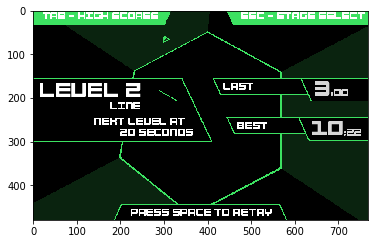

In [1]:
from IPython.display import display, clear_output

import os
import glob
import numpy as np
import skimage.io
import ipywidgets as widgets

from redis import StrictRedis

import matplotlib.pyplot as plt
%matplotlib inline


CLASSIFIER_NAME = "GAME_AREA"

redis_client = StrictRedis()

files = os.scandir("datasets/collect_frames")
frame_uuid = None

def next_frame():
    clear_output(wait=True)
    file = next(files)
    
    global frame_uuid
    frame_uuid = file.name.split("_")[1].replace(".png", "")

    redis_key = f"PROJECT_EC:{CLASSIFIER_NAME}:{frame_uuid.upper()}"
    if redis_client.get(redis_key) is not None:
        return next_frame()

    if file.is_file:
        frame_image = skimage.io.imread(file.path)
    
        plt.figure()
        plt.imshow(frame_image)
    else:
        return next_frame()

def on_frame_submit(w):
    value = w.value
    
    redis_key = f"PROJECT_EC:{CLASSIFIER_NAME}:{frame_uuid.upper()}"
    redis_count_key = f"PROJECT_EC:{CLASSIFIER_NAME}_COUNTS:{value.upper()}"
    
    redis_client.set(redis_key, value)
    
    current_count = redis_client.get(redis_count_key)
    
    if current_count is None:
        redis_client.set(redis_count_key, 1)
    else:
        current_count = int(current_count.decode("utf-8"))
        redis_client.set(redis_count_key, current_count + 1)
    
    w.value = ""
    next_frame()
    
frame_widget = widgets.Text(
    value="",
    placeholder="Enter the label for the frame you see...",
    description=""
)

frame_widget.on_submit(on_frame_submit)

display(frame_widget)

next_frame()

# LABELS
# g = Game
# l = Level Select
# s = Splash Screen
# d = Death Screen

## Stats

In [12]:
total_samples = len(redis_client.keys(f"PROJECT_EC:{CLASSIFIER_NAME}:*"))
total_samples

214

In [14]:
count_keys = redis_client.keys(f"PROJECT_EC:{CLASSIFIER_NAME}_COUNTS:*")
counts = list()

for count_key in count_keys:
    count_key = count_key.decode("utf-8")
    label = count_key.replace(f"PROJECT_EC:{CLASSIFIER_NAME}_COUNTS:", "")
    count = int(redis_client.get(count_key).decode("utf-8"))
    
    counts.append((label, count))

sorted_top = sorted(counts, key=lambda c: c[1], reverse=True)

print("\nTOP")
for t in sorted_top:
    print(f"{t[0]}: {t[1]}")

[]

TOP


In [15]:
def generate_labels():
    count_keys = redis_client.keys(f"PROJECT_EC:{CLASSIFIER_NAME}_COUNTS:*")
    labels = list()
    
    for count_key in count_keys:
        count_key = count_key.decode("utf-8")
        label = count_key.replace(f"PROJECT_EC:{CLASSIFIER_NAME}_COUNTS:", "")

        labels.append(label) if len(label) < 2 else ""
    
    return sorted(labels)

labels = generate_labels()
labels

[]

In [98]:
def generate_data_and_targets():
    keys = redis_client.keys(f"PROJECT_EC:{CLASSIFIER_NAME}:*")
    
    data = list()
    targets = list()
    
    for key in keys:
        key = key.decode("utf-8")
        uuid = key.split(":")[-1].lower()
        
        try:
            file_path = glob.glob(f"datasets/collect_frames/frame_{uuid}*")[0]
        except IndexError:
            continue
        
        frame = skimage.io.imread(file_path)
        processed_frame = process_frame(frame)
        
        data.append(processed_frame.astype(np.bool).flatten())
        
        target = redis_client.get(key)        
        targets.append(target.decode("utf-8"))
        
    return (data, targets)
    
data, targets = generate_data_and_targets()

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.io
import skimage.transform

from skimage.filters import threshold_local
from skimage.color import rgb2gray

def process_frame(frame):
    gray_frame = rgb2gray(frame)
    
    threshold = threshold_local(gray_frame, 21)
    bw_frame = gray_frame > threshold
    
    return skimage.transform.resize(bw_frame, (30, 48), mode="reflect", order=0)

In [99]:
from sklearn import svm
classifier = svm.SVC(gamma=0.001, C=100)

classifier.fit(data[:-10], targets[:-10])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [100]:
import pickle

serialized_classifier = pickle.dumps(classifier)

with open("datasets/super_hexagon_context.model", "wb") as f:
    f.write(serialized_classifier)

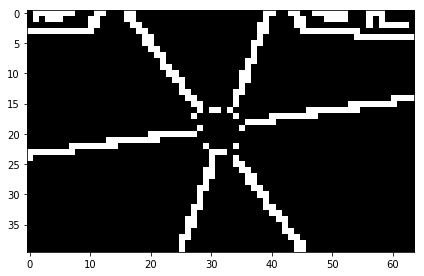

In [91]:
frame = data[-6].reshape(30, 48)
skimage.io.imshow(frame)

In [95]:
classifier.predict([data[-6]])[0]

'1'